**Time Series Analisys**

In [11]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from datetime import datetime
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL

### **Functions**

In [193]:
def dicky_fuller(df):
  """
  Perform the Augmented Dickey-Fuller test on a given dataframe.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to perform the ADF test on.
    
    Returns:
    None: This function will print the ADF statistic, p-value, critical values, and the result of the test.
    
    Example:
    dicky_fuller(df)
  """
  dik_fuller = adfuller(df)
  print('ADF Statistic: %f' % dik_fuller[0])
  print('p-value: %f' % dik_fuller[1])
  print('Critical Values:')
  for key, value in dik_fuller[4].items():
      print('\t%s: %.3f' % (key, value))

  if dik_fuller[0] < dik_fuller[4]["5%"]:
      print ("Reject Ho - Time Series is Stationary")
  else:
      print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [194]:
def decomposition_plot(df):
  """
    Plot the decomposition of time series into trend, seasonal, and residual components.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to perform the decomposition on.
    
    Returns:
    None: This function will create and show the decomposition plot.
    
    Example:
    decomposition_plot(df)
  """
  rcParams['figure.figsize'] = (18, 8)
  decomposition = sm.tsa.seasonal_decompose(df, model='additive')
  fig = decomposition.plot()
  plt.show()

In [195]:
def afc_pafc_plot(df):
  """
    Plot the Auto-correlation and Partial Auto-correlation functions of a given time series data.
    
    Parameters:
    df (pd.DataFrame): The DataFrame of the time series data.
    
    Returns:
    None: This function will create and show the Auto-correlation and Partial Auto-correlation plots.
    
    Example:
    afc_pafc_plot(df)
  """
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
  sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
  sm.graphics.tsa.plot_pacf(df.values.squeeze(), lags=40, ax=ax2)
  plt.show()

In [196]:
def time_series_data_cleaning(df):
  """
      Clean and prepare time series data by converting the date column 
      to datetime format, setting it as the index, and resampling the data by month.
    Parameters:
    df (pd.DataFrame): The DataFrame containing the time series data. The DataFrame should contain a date column and a sales column.
    
    Returns:
    pd.Series: The cleaned and resampled time series data, with the date column as the index and the sales column as the values.
    
    Example:
    time_series_data_cleaning(df)
  """
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df.index = df['date']
  return df['sales'].resample('15D').mean()

In [197]:
def time_series_plot(df):
  """
      Plot a time series data with a title, labeled axis, and a horizontal line at 0
    Parameters:
    df (pd.Series): The time series data to plot.
    
    Returns:
    None: This function will create and show the time series plot.
    
    Example:
    time_series_plot(df)
  """
  plt.figure(figsize=(8,6))
  plt.title('Sales over time')
  plt.plot(df)
  plt.axhline(0, linestyle='--', color='k', alpha=0.3)

In [198]:
def train_test_split(df):
  """
   Split a dataframe into training and testing sets.
    
    Parameters:
    df (pd.DataFrame): The dataframe to split.
    
    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the training set and testing set respectively.
    
    Example:
    train_data, test_data = train_test_split(df)
  """
  test_length = int(0.3 * df.shape[0])
  train_data = df[:-test_length]
  test_data = df[-test_length:]
  return train_data, test_data

In [199]:

def calculate_mape(prediction_set, test_set):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between a prediction and a test set.
    
    Parameters:
        prediction_set (np.ndarray): The predicted values.
        test_set (np.ndarray): The actual values.
        
    Returns:
        mape (float): The MAPE value.
    """
    # Ensure that the inputs are numpy arrays
    prediction_set = np.array(prediction_set)
    test_set = np.array(test_set)
    
    # Calculate the absolute percentage error
    ape = np.abs((test_set - prediction_set) / test_set)
    
    # Calculate the mean absolute percentage error
    mape = np.mean(ape)
    
    return mape

### **1) Data cleaning and preprocessingg**

In [200]:
data = pd.read_csv('data.csv')

In [201]:
data.head()

,store,sku,date,sales
0,1186,601516,2016-02-04,20.0
1,1186,601516,2016-02-05,11.0
2,1186,601516,2016-02-06,10.0
3,1186,601516,2016-02-08,10.0
4,1186,601516,2016-02-09,10.0


In [202]:
data.shape

(161529, 4)

In [203]:
data.describe()

,store,sku,sales
count,161529.000000,1.615290e+05,161529.000000
mean,496.040191,2.000777e+13,6.544224
std,769.078682,4.782248e+13,17.961465
min,2.000000,6.011050e+05,-150.000000
25%,68.000000,6.011050e+05,1.000000
50%,141.000000,6.019000e+05,2.000000
75%,317.000000,9.010002e+08,5.000000
max,6301.000000,2.020000e+14,1120.000000


**Checking for null values**

In [204]:
print(data.isnull().sum())

store    0
sku      0
date     0
sales    0
dtype: int64


In [205]:
print( 'Number of unique stores:',len(data['store'].unique()))
print( 'Number of unique items:',len(data['sku'].unique()))

Number of unique stores: 147
Number of unique items: 303


**Checking for duplicates**

In [206]:
data[data.duplicated()]

,store,sku,date,sales


By definition, a time series is a set of data points collected at regular time intervals. In this case, the data does not conform to this criterion as it lacks regularity in its time intervals. Therefore, it is necessary to resample the data in order to make it suitable for time series analysis and forecasting.

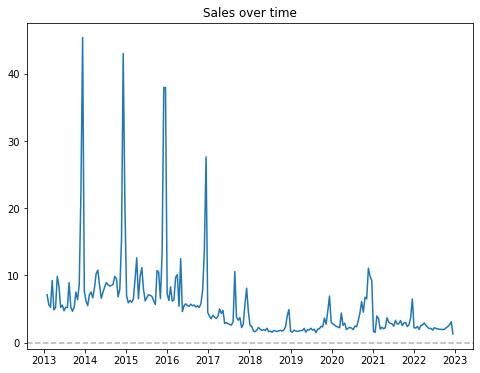

In [207]:
y = time_series_data_cleaning(data)
time_series_plot(y)

In the plot above we have a time series of sales over time with a 15 day time interval. The data shows high decreasing volatility and a seasonal effect.

### **2) Stationarity check, Decomposition and Data visualization**

**Cheking for stationary using Augmented Dickey-Fuller test**

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationary time series have a constant mean and variance over time, and are predictable, while non-stationary time series have a mean and/or variance that changes over time and are less predictable. The ADF test measures the strength and direction of the relationship between a time series and a lagged version of itself. If the relationship is weak and not statistically significant, the time series is likely to be stationary. If the relationship is strong and statistically significant, the time series is likely to be non-stationary and would need to be differenced before modeling. 

In [208]:
dicky_fuller(y)

ADF Statistic: -5.779536
p-value: 0.000001
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject Ho - Time Series is Stationary


In this case, the test statistic of the Dickey-Fuller test was found to be less than the critical value, which means that the null hypothesis can be rejected. This suggests that the data is stationary. Stationarity is a key assumption in many time series forecasting models, and it's important to check for stationarity before building a model.





#### **Data visualization**

The transformation applied to the data has removed the seasonal and trend component, which is important as most time series techniques assume that the data is stationary. And we can proceed with applying time series techniques.

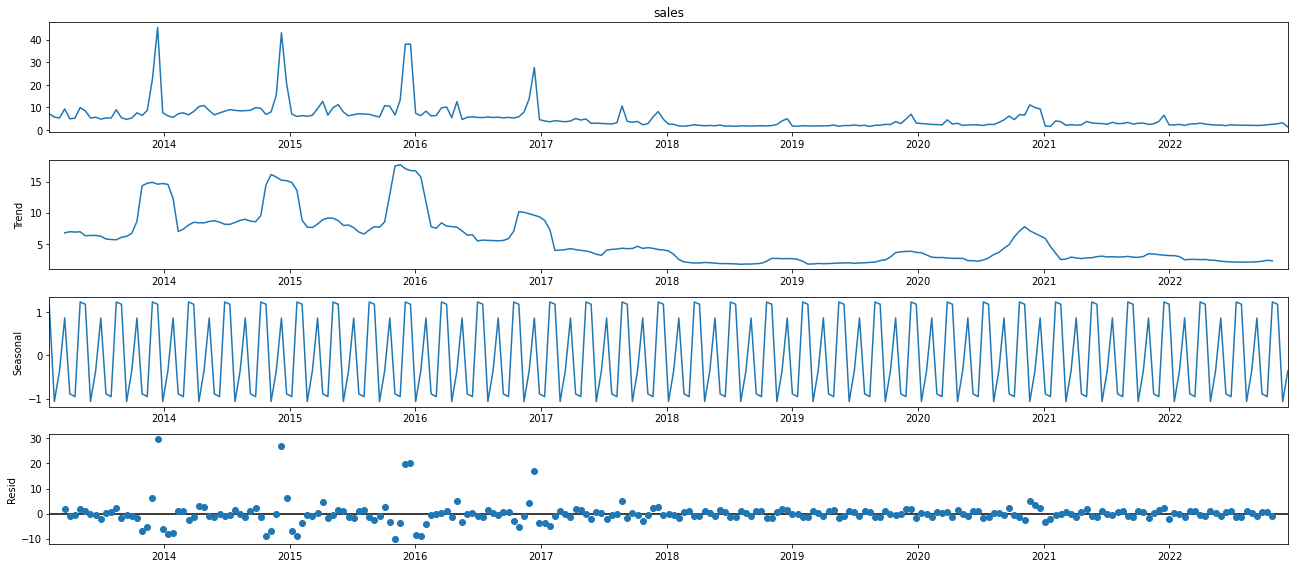

In [209]:
decomposition_plot(y)

The decomposition plot reveals a pronounced seasonal component, which may indicate that a sarima model may be a good fit. Additionally, an elevated level of residuals at the end of each year between 2014 and 2017, which may be a sign for anomalies.

PACF is a plot of the correlation between a time series and lagged versions of itself, with the linear dependence of intervening comparisons removed. It helps to identify the number of lags required for a stationary time series and also helps in identifying the type of model that best fits the data.

Both ACF and PACF are used together to identify the order of differencing required for a time series to make it stationary. If the ACF plot has a slow decay and the PACF plot has a sharp cut-off, then the time series is likely an autoregressive (AR) process. If the ACF plot has a slow decay and the PACF plot also has a slow decay, then the time series is likely a moving average (MA) process. If both ACF and PACF plots have a slow decay, then the time series is likely a combination of both AR and MA processes, and therefore it may be an ARIMA 

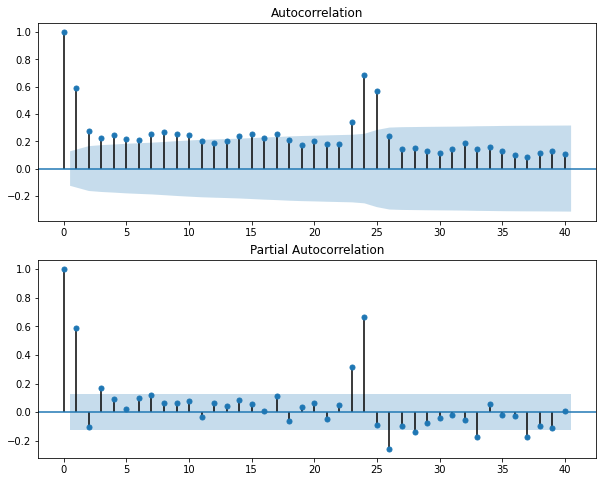

In [210]:
afc_pafc_plot(y)

The above plots suggest that the autocorrelation function (AFC) has a slow decay with a few significant lags, while the partial autocorrelation function (PACF) indicates that the first lag is significant. The fact that the data is stationary, combined with These findings, suggest that an ARMA(1,4) model may be appropriate for this time series.

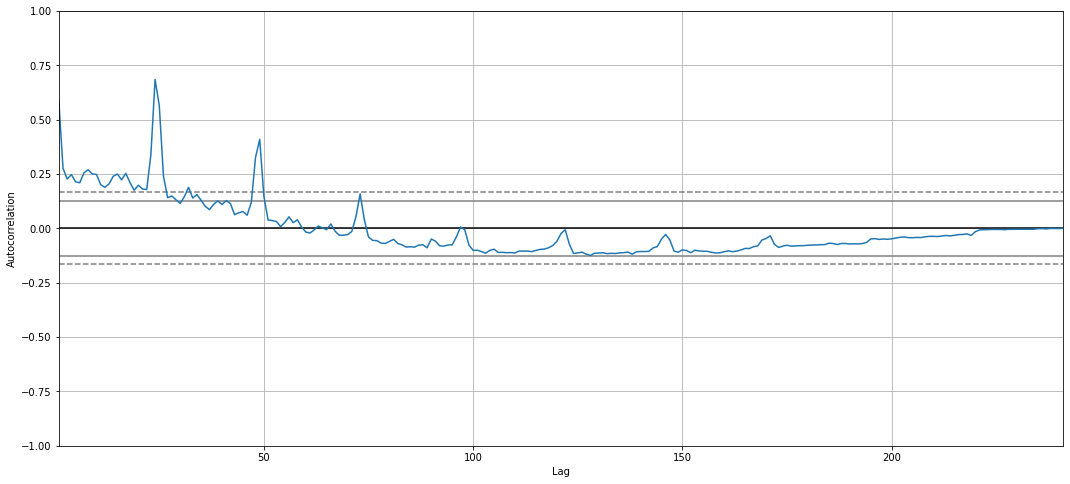

In [211]:
autocorrelation_plot(y)
plt.show()

Autocorrelation plot is a graphical representation of the correlation between different lags of a time series data. based on the plot the data is is somewhatt significantly correlated with the beginnig lags. then starts to decend.

### **3) Model Selection**



Splitting the data to a train and test sets.

In [212]:
#split to train and test
df_train , df_test = train_test_split(y)

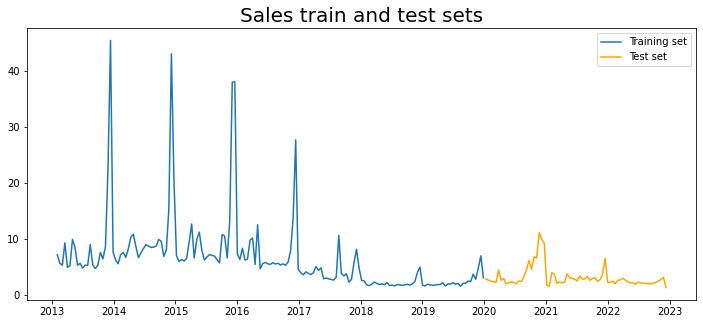

In [213]:
plt.figure(figsize = (12,5))
plt.title('Sales train and test sets', size=20)
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend();

ARMA (AutoRegressive Moving Average) and SARIMA (Seasonal AutoRegressive Integrated Moving Average) are two common models used for time series forecasting.

The main difference between the two models is that SARIMA takes into account the seasonal component of a time series, while ARMA does not. A time series is considered seasonal if it shows a regular pattern of fluctuations at specific time intervals, such as daily, weekly, or yearly. SARIMA models the seasonal component by adding additional parameters to the model, such as P, D, and Q, which model the seasonal autoregression, difference and moving average, respectively.


> Benefits of ARMA model:



* Simple model that is easy to understand and implement.
* Requires less data to estimate parameters.

> Disadvantages of ARMA model:
* Does not account for the possible seasonality in the data, which can lead to  inaccurate predictions if the data is seasonal.
> Benefits of SARIMA model:
* Handles non-stationary data by including the integrated component.
* Accounts for the seasonal component of the data, making it more suitable for time series with regular patterns of fluctuations.
> Disadvantages of SARIMA model:
* Requires more data to estimate parameters.
* Complex model that may be harder to understand and implement.
* Difficult to select appropriate values for the seasonal and non-seasonal parameters.



#### **ARMA(1,4) model**

In [214]:
model_arma = ARIMA(df_train, order = (1,0,4))
arma_fit = model_arma.fit()
arma_predictions = arma_fit.predict(start = df_test.index[0], end = df_test.index[-1], typ = 'levels')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Negative indices (that lie in the Index)


In [215]:
print(arma_fit.summary())
# model stats
print(f"Mean Absolute Percent Error: {round(calculate_mape(arma_predictions,df_test),4)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(df_test, arma_predictions)) ,3)}")
print(f"R2score is {round(r2_score(df_test.values, arma_predictions.values),2)}")


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  169
Model:                 ARIMA(1, 0, 4)   Log Likelihood                -521.476
Date:                Sat, 21 Jan 2023   AIC                           1056.952
Time:                        17:36:23   BIC                           1078.862
Sample:                    02-01-2013   HQIC                          1065.843
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0674      5.885      1.031      0.303      -5.468      17.602
ar.L1          0.9836      0.040     24.555      0.000       0.905       1.062
ma.L1         -0.3982      0.067     -5.903      0.0

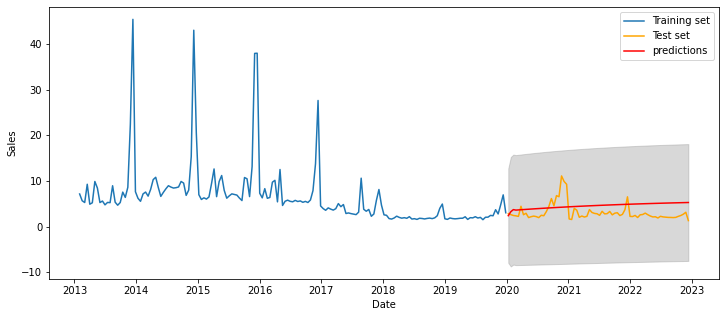

In [216]:
arma_forecast = arma_fit.get_forecast(steps = len(df_test))
arma_forecast_conf = arma_forecast.conf_int()
arma_cf = pd.DataFrame(arma_forecast_conf)
plt.figure(figsize = (12,5))
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.plot(arma_predictions, label='predictions', color='red')
plt.fill_between(arma_cf.index,arma_cf.iloc[:, 0],arma_cf.iloc[:, 1],color='grey',alpha=.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

The ARMA model was unable to capture the seasonal effect.

<Figure size 864x360 with 0 Axes>

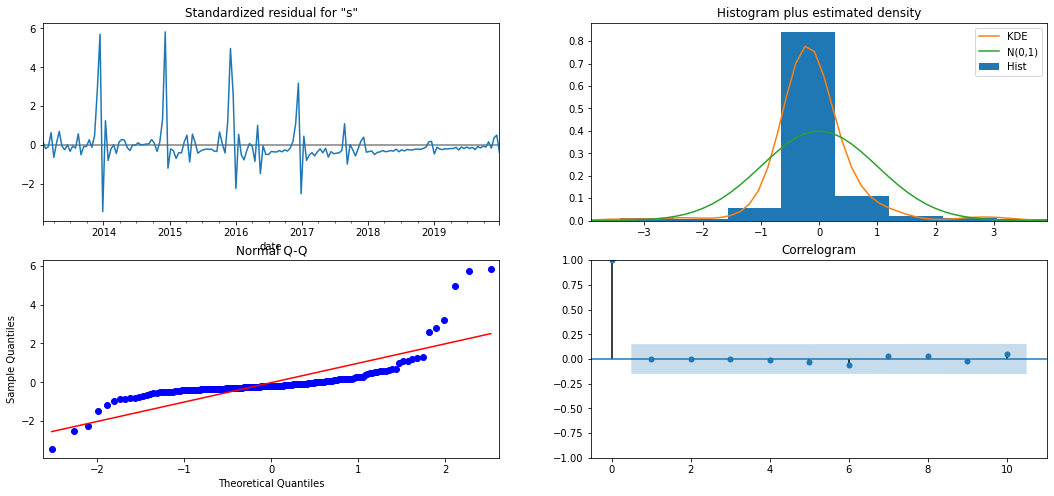

In [217]:
plt.figure(figsize = (12,5))
arma_fit.plot_diagnostics()
plt.show()

We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution. This means that further analysis and adjustments may be needed to improve the model's performance.

#### **SARIMA model**

The auto_arima function will do a stepwise search to find the best parameters within the bounds that are set. 

In [218]:
#Running the auto_arima
auto_model = auto_arima(y=df_train, start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=12, max_order=None,
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1098.367, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1099.503, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1087.358, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1096.370, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1086.019, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1086.510, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1059.836, Time=0.53 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=948.827, Time=1.07 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=946.901, Time=0.54 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=948.770, Time=1.47 sec
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=947.324, Time=3.77 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1007.447, Time=0.31 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=942.587, Time=1.24 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(3,0,0)[12] inte

In [219]:
prediction, confint  = auto_model.predict(n_periods = df_test.shape[0], index = df_test.index,return_conf_int=True)
residuals = df_test - prediction
print(auto_model.summary())
# model stats
print(f"Mean Absolute Percent Error: {round(calculate_mape(prediction,df_test),4)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(df_test, prediction)) ,3)}")
print(f"R2score is {round(r2_score(df_test.values, prediction.values),2)}")

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  169
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 12)   Log Likelihood                -464.552
Date:                             Sat, 21 Jan 2023   AIC                            939.103
Time:                                     17:37:09   BIC                            954.723
Sample:                                 02-01-2013   HQIC                           945.442
                                      - 12-27-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6677      0.054    -12.450      0.000      -0.773      -0.563
ma.L2         -0.2356      

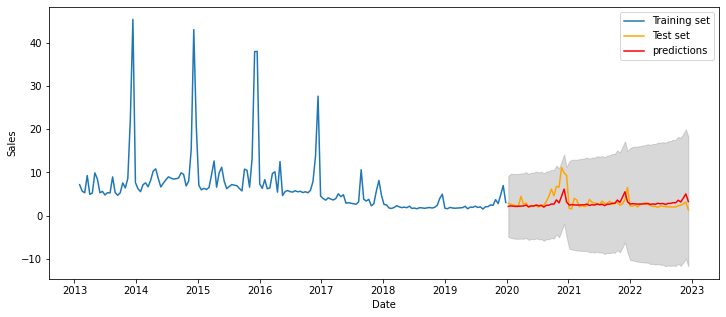

In [220]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=df_test.index)
plt.figure(figsize = (12,5))
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.plot(prediction, label='predictions', color='red')
plt.fill_between(prediction_series.index,cf[0],cf[1],color='grey',alpha=.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

The SARIMA model's prediction line appears to align more closely with the test set data. Additionally, the shrinkage of the confidence interval indicates an increase in the model's level of certainty in its predictions.

<Figure size 864x648 with 0 Axes>

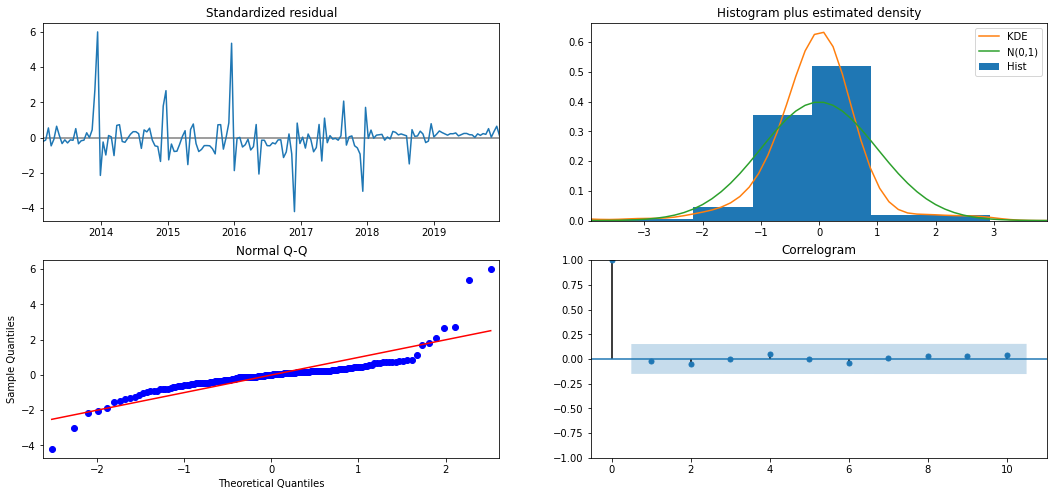

In [221]:
plt.figure(figsize = (12,9))
auto_model.plot_diagnostics()
plt.show()

The diagnostic plots indicate that the errors in the model are not correlated, indicating a well-performing model. Furthermore, the QQ plot shows that the residual errors have a more normal distribution more than the ARMA model, which is a commonly assumed assumption in statistical models. The overall performance of this model is better than the ARMA model as it can be seen in the reduction of Mean Absolute Percent Error.

### **4) Fine tuning and anomaly detection**

#### **Anomalies detection:**
Seasonal-Trend Decomposition using LOESS (STL) is a method for decomposing a time series into its seasonal, trend, and remainder components. It uses a technique called locally weighted regression (LOESS) to model the trend and seasonal components. The remainder component is the residual of the decomposition and represents the irregular or unpredictable variations in the time series. This method is useful for identifying patterns in time series data and detecting anomalies in the data.

In [222]:
#Seasonal, trend and residual decompesition
stl = STL(y)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

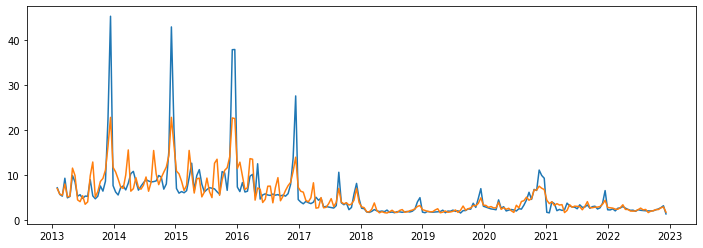

In [223]:
#plotting the trend + seasonal vs the real data. 
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(y)
plt.plot(estimated)

The ponts that are above the orange line(trend + seasonal component) may be an anomaly.

creating a bound of mean +- three standard deveations

(734869.0, 738855.0)

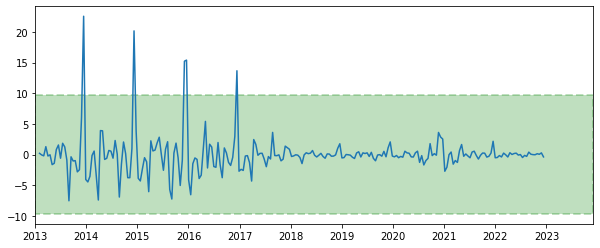

In [224]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2013,1,1), datetime(2023,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2013,1,1), datetime(2023,12,1))

Here we cn see the anomalies highlighted on the plot

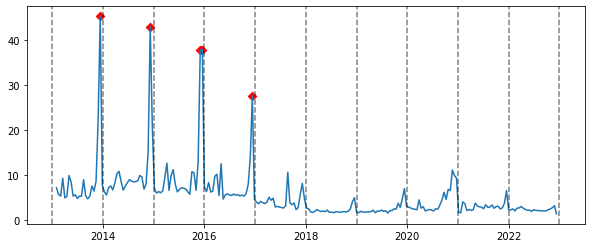

In [225]:
anomalies = y[(resid < lower) | (resid > upper)]
plt.figure(figsize=(10,4))
plt.plot(y)
for year in range(2013,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies, color='r', marker='D')

In [226]:
anomalies = y[(resid < lower) | (resid > upper)]
print('Number of anomalies:', anomalies.count())

Number of anomalies: 5


In [227]:
print(anomalies)

date
2013-12-13    45.403333
2014-12-08    43.021577
2015-12-03    37.940276
2015-12-18    37.982600
2016-12-12    27.624315
Name: sales, dtype: float64


We can see that all the anomalies occur in the month december

I will now standardize the values of the five anomalous data points by subtracting the mean.


In [228]:
y_clean =  y.copy()
row_indices = anomalies.index
# Change the values of the specified rows to the mean
y_clean.loc[row_indices] = y_clean.mean()

The anomalies new values.

In [229]:
y_clean.loc[row_indices]

date
2013-12-13    5.519679
2014-12-08    5.519679
2015-12-03    5.519679
2015-12-18    5.519679
2016-12-12    5.519679
Name: sales, dtype: float64

Checking if the data remains stationary after shrinking the anomalies.

In [230]:
dicky_fuller(y_clean)

ADF Statistic: -1.429616
p-value: 0.567999
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Failed to Reject Ho - Time Series is Non-Stationary


##### **methods to make the data stationary:**
In this section I implement a code that converts non-stationary data to stationary.

Differencing is a technique used to make a time series stationary. A time series is considered stationary if its statistical properties such as mean, variance, and autocorrelation are constant over time.

One way to make a time series stationary is to use differencing, which involves subtracting the current value from the previous value in the series. This process is called first-order differencing, as it uses a lag of 1. The resulting series will be stationary if the original series was not.

In [231]:
# difference between p(t) - p(t-1) 
transformed_y = y_clean.diff().dropna()

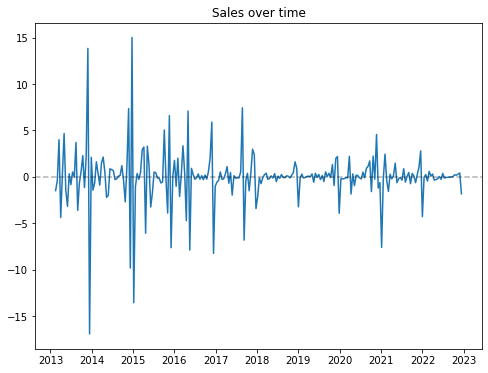

In [232]:
time_series_plot(transformed_y)

In [233]:
#Running the dicky-Fuller test on the transformed data
dicky_fuller(transformed_y)

ADF Statistic: -8.113128
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Reject Ho - Time Series is Stationary


#### **Constructing a SARIMAX model**

The main difference between SARIMA and SARIMAX models is that SARIMA models only consider the internal structure of the time series data and do not incorporate any external variables. SARIMAX models consider the internal structure of the time series data as well as any external variables that may have an impact on the time series. These variables are called exogenous variables and are used as predictors in the model. Examples of exogenous variables include weather conditions, economic indicators, ect. In this case I am simply going to add the month number as an exogenous variable.

The train and test sets will be extracted from the y_transformed dataset, which has undergone a process of anomaly reduction and difference transformation to ensure stationarity.

In [234]:
df_train , df_test = train_test_split(transformed_y)

In [235]:
#SARIMAX Model
SARIMAX_model = auto_arima(df_train, exogenous=df_train.index.month,
                           start_p=0, start_q=0, max_p=5, 
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=12, max_order=None,
                           trace=True)    

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=885.544, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=836.188, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=796.878, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=883.553, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=795.089, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=796.774, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=793.094, Time=0.51 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=788.167, Time=0.80 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=786.352, Time=0.45 sec
 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=788.210, Time=1.11 sec
 ARIMA(0,0,1)(3,0,1)[12] intercept   : AIC=790.157, Time=2.65 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=876.353, Time=0.28 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=788.206, Time=0.97 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=788.202, Time=0.65 sec
 ARIMA(1,0,0)(2,0,0)[12] intercep

In [236]:
prediction_sarimax, confint_sarimax  = SARIMAX_model.predict(n_periods = df_test.shape[0], index = df_test.index,return_conf_int=True)
residuals = df_test - prediction_sarimax
print(SARIMAX_model.summary())
# model stats
print(f"Mean Absolute Percent Error: {round(calculate_mape(prediction_sarimax,df_test),4)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mean_squared_error(df_test, prediction_sarimax)) ,3)}")
print(f"R2score is {round(r2_score(df_test.values, prediction_sarimax.values),2)}")

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  168
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood                -388.352
Date:                             Sat, 21 Jan 2023   AIC                            784.704
Time:                                     17:37:25   BIC                            797.200
Sample:                                 02-16-2013   HQIC                           789.775
                                      - 12-27-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8836      0.045    -19.731      0.000      -0.971      -0.796
ar.S.L12      -0.0268      

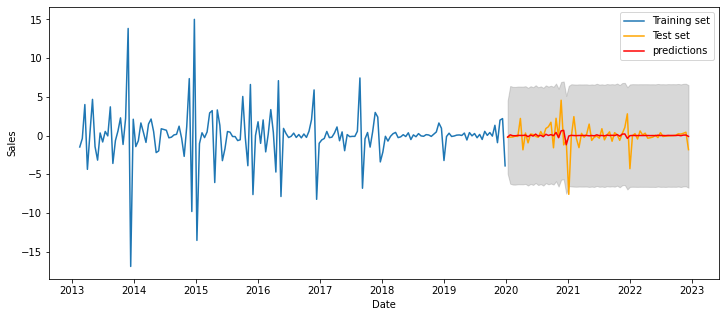

In [237]:
cf_sarimax= pd.DataFrame(confint_sarimax)
prediction_series = pd.Series(prediction_sarimax,index=df_test.index)

plt.figure(figsize = (12,5))
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.plot(prediction_sarimax, label='predictions', color='red')
plt.fill_between(prediction_series.index,cf_sarimax[0],cf_sarimax[1],color='grey',alpha=.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

We can see that the predicted line over shoots the target. 

<Figure size 864x360 with 0 Axes>

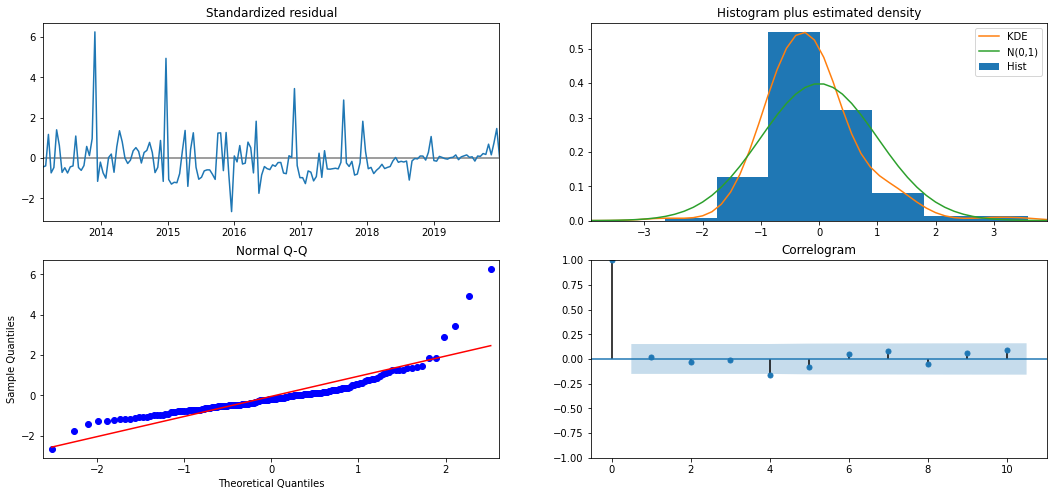

In [238]:
plt.figure(figsize = (12,5))
SARIMAX_model.plot_diagnostics()
plt.show()

It appears that the SARIMAX model, which includes exogenous variables, did not perform as well as the SARIMA model, based on the visualizations and model statistics. The mean absolute percent error has increased closer to the ARMA model, which may be due to the inclusion of the exogenous variable and the reduction of the anonalies. The model selection and the effect of exogenous variables should be further evaluated to determine the best approach for forecasting this specific time series.

###  **5)**











>  In this section I will review a modern Time series model the Long Short-Term Memory (LSTM) model. LSTM is a type of Recurrent Neural Network (RNN) that is designed to handle sequential data with long-term dependencies. It is particularly useful for time series forecasting tasks where the data has complex patterns and dependencies over time.

LSTMs can learn and remember patterns in the data over long periods of time, making them well-suited for time series forecasting. They have an internal memory cell that can store information over a prolonged period of time, which allows them to maintain a better understanding of the context of the data. Additionally, LSTMs can handle missing data and variable-length sequences, which makes them robust to real-world data.

LSTMs can also be used in combination with other techniques such as attention mechanisms, which allow the model to focus on specific parts of the data and learn more complex patterns. Furthermore, LSTMs can be stacked to form a deeper network, which can further improve their performance.

While LSTMs are more complex and computationally expensive than traditional time series models like ETS, they offer better performance and flexibility for handling complex patterns in time series data.


LSTMs are particularly well-suited for time series forecasting tasks where the data has a decreasing volatility and high seasonal affect. 

LSTMs have the ability to learn and remember patterns in the data over long periods of time. This means that they are able to capture the long-term dependencies in the data, which is important when forecasting time series with high seasonal affect. For example, LSTMs can identify patterns in the data that repeat every year, such as sales patterns during holidays, and use this information to make more accurate predictions.

LSTMs are robust to missing data and variable-length sequences. This is important when dealing with time series data that has decreasing volatility. For example, if a time series has a decreasing volatility, there may be periods of time where the data is missing or the length of the time series is not consistent. LSTMs can handle these situations and still make accurate predictions.

LSTMs can handle non-linearity and non-stationarity. As we know that time series data can be non-linear and non-stationary, which means that the mean and variance of the data may change over time. LSTMs are well-suited for handling non-linearity and non-stationarity, which makes them a good choice for time series data with high volatility.

LSTMs are able to capture the context of the data through their internal memory cell. This means that they can maintain a "memory" of past observations and use this information to make more accurate predictions. This is particularly useful when dealing with time series data that has a high seasonal affect like the data in this case. For example, an LSTM can use information from past seasons to make more accurate predictions for the current season, even if the volatility of the data has decreased.

In summary, LSTMs are a powerful tool for time series forecasting, and they are particularly well-suited for time series data that has a decreasing volatility and high seasonal affect. Their ability to learn and remember patterns over long periods of time, handle missing data and variable-length sequences, handle non-linearity and non-stationarity, and capture the context of the data, makes them a suitable model for such kind of data.






### **6)**

One strategy for inventory management that can ensure a 95% on-demand rate from the test set would be to use an ensemble of forecasting techniques coupled with safety stock calculations.

First, I would use historical data from the train set to create a robust forecasting model by applying a variety of techniques such as exponential smoothing, ARIMA, and machine learning-based models. I would then use techniques such as cross-validation, AIC and BIC values to evaluate and select the best performing model.

Next, I would calculate the safety stock level for each product in the inventory using the selected forecasting model and taking into account the desired service level (95% in this case) and lead time. I would also consider incorporating external factors that may affect demand such as promotions or market trends.

I would then use the forecast and safety stock levels to determine the optimal inventory levels for each product by setting a reorder point that is a certain number of standard deviations above the forecasted demand. The goal should be to order just enough inventory to meet the forecasted demand plus the safety stock level.

I would continuously monitor and adjust the inventory levels and forecast and safety stock levels as needed. This would involve regularly reviewing the forecast accuracy and using the actual demand from the test set to adjust the model and safety stock levels. I would also consider implementing a feedback loop to improve the forecasting model by incorporating the impact of inventory management decisions on the demand.

Additionally, I would suggest techniques such as ABC analysis to prioritize which items to order more or less of based on their importance, this could be done by analyzing their contribution to the profit, sales, and storage costs.
Implementing a just-in-time (JIT) inventory management system, that is, ordering inventory just in time to meet the forecasted demand. This will help to minimize storage and transport costs as well as keeping the inventory levels low.

In summary, the strategy I proposed is a combination of forecasting techniques and safety stock calculations that aims to ensure a 95% on-demand rate from the test set. The forecasting model can be fine-tuned on the train set to ensure accurate predictions of the demand, while the safety stock calculations can provide a safety net to ensure that demand can be met even if the forecast is not perfect. Additionally, I would continuously monitor and improve the system to ensure that it's always optimized to the current market conditions.